![image](https://github.com/Lexie88rus/iWildCam/raw/master/assets/cover_image.jpg)

*Photo by [Sarah Bliss](https://unsplash.com/@squeakypeachphotos?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText) on [Unsplash](https://unsplash.com/s/photos/wild-animals?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText)*

# iWildCam EDA

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import json
from datetime import datetime

from PIL import Image

import matplotlib.pyplot as plt

## Introduction
Camera Traps (or Wild Cams) enable the automatic collection of large quantities of image data. Biologists all over the world use camera traps to monitor biodiversity and population density of animal species. However, as we try to expand the scope of the species classification models we are faced with an interesting problem: how do we train models that perform well on new (unseen during training) camera trap locations? Can we leverage data from other modalities, such as citizen science data and remote sensing data?

The challenge of [this competition](https://www.kaggle.com/c/iwildcam-2020-fgvc7/overview) is to classify species in the cameras correctly given the test and training data from different cameras spread across the globe. The set of species seen in each camera overlap, but are not identical. 

In this notebook I'd like to give some overview of the data.

## Load Data

Get the list of files in the dataset:

In [2]:
! ls ../input/iwildcam-2020-fgvc7

iwildcam2020_megadetector_results.json	sample_submission.csv
iwildcam2020_test_information.json	test
iwildcam2020_train_annotations.json	train


Load the train annotations data:

In [3]:
# setup the directories
DATA_DIR = '../input/iwildcam-2020-fgvc7/'
TRAIN_DIR = DATA_DIR + 'train/'
TEST_DIR = DATA_DIR + 'test/'

# load the megadetector results
megadetector_results = json.load(open(DATA_DIR + 'iwildcam2020_megadetector_results.json'))
#megadetector_results['images'][:2]

# load train images annotations
train_info = json.load(open(DATA_DIR + 'iwildcam2020_train_annotations.json'))
# split json into several pandas dataframes
train_annotations = pd.DataFrame(train_info['annotations'])
train_images = pd.DataFrame(train_info['images'])
train_categories = pd.DataFrame(train_info['categories'])

# load test images info
test_info = json.load(open(DATA_DIR + 'iwildcam2020_test_information.json'))
# split json into several pandas dataframes
test_images = pd.DataFrame(test_info['images'])
test_categories = pd.DataFrame(test_info['categories'])

Look at the dataframes containing the train set annotations:

1. The list of images and corresponding category ids:

In [4]:
train_annotations.head()

,count,image_id,id,category_id
0,1,96b00332-21bc-11ea-a13a-137349068a90,a292dd3c-21bc-11ea-a13a-137349068a90,73
1,1,879d74d8-21bc-11ea-a13a-137349068a90,a0afcfc0-21bc-11ea-a13a-137349068a90,4
2,1,9017f7aa-21bc-11ea-a13a-137349068a90,a306e9c0-21bc-11ea-a13a-137349068a90,227
3,1,90d93c58-21bc-11ea-a13a-137349068a90,9eed94c4-21bc-11ea-a13a-137349068a90,250
4,1,887cd0ec-21bc-11ea-a13a-137349068a90,a2a4dd7a-21bc-11ea-a13a-137349068a90,2


2. Train images sequence information (locations of cameras, sequences of images from same locations, image timestamps):

In [5]:
train_images.head()

,seq_num_frames,location,datetime,id,frame_num,seq_id,width,height,file_name
0,1,267,2013-08-08 11:45:00.000,96b00332-21bc-11ea-a13a-137349068a90,1,96b004ea-21bc-11ea-a13a-137349068a90,1795,1222,96b00332-21bc-11ea-a13a-137349068a90.jpg
1,1,264,2013-08-01 22:31:00.000,879d74d8-21bc-11ea-a13a-137349068a90,1,879d7654-21bc-11ea-a13a-137349068a90,2739,1772,879d74d8-21bc-11ea-a13a-137349068a90.jpg
2,1,45,2013-04-17 11:15:00.000,9017f7aa-21bc-11ea-a13a-137349068a90,1,9017f8cc-21bc-11ea-a13a-137349068a90,1891,1222,9017f7aa-21bc-11ea-a13a-137349068a90.jpg
3,1,45,2013-04-23 08:26:00.000,90d93c58-21bc-11ea-a13a-137349068a90,1,90d93e38-21bc-11ea-a13a-137349068a90,1795,1222,90d93c58-21bc-11ea-a13a-137349068a90.jpg
4,1,45,2013-04-24 13:51:00.000,887cd0ec-21bc-11ea-a13a-137349068a90,1,887cd29a-21bc-11ea-a13a-137349068a90,1812,1196,887cd0ec-21bc-11ea-a13a-137349068a90.jpg


3. The description of categories:

In [6]:
train_categories.head()

,count,id,name
0,78981,0,empty
1,6355,2,tayassu pecari
2,5833,3,dasyprocta punctata
3,619,4,cuniculus paca
4,4453,6,puma concolor


## Train Set Statistics

`1` Get the total number of images in the train and test sets:

In [7]:
print('Number of images in the train set is {}'.format(train_annotations.image_id.nunique()))
print('Number of images in the test set is {}'.format(test_images.file_name.nunique()))

Number of images in the train set is 217959
Number of images in the test set is 62894


Visualize train and test sets:

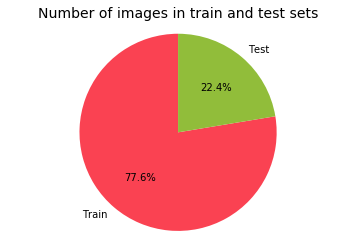

In [8]:
plt.pie([train_annotations.image_id.nunique(), test_images.file_name.nunique()], labels=['Train', 'Test'], autopct='%1.1f%%', 
           startangle=90, colors=['#fa4252', '#91bd3a'])
plt.axis('equal')
plt.title('Number of images in train and test sets', fontsize=14)
plt.show()

`2` Let's check the number of animals found per image:

In [9]:
# get the number of counts per image
# sort values in descending order
counts_per_image = train_annotations.groupby(by=['image_id']).sum().reset_index()[['image_id', 'count']].sort_values(by=['count'], ascending=False)
# output top-5
counts_per_image.head(5)

,image_id,count
130497,91d0f146-21bc-11ea-a13a-137349068a90,80
190827,97062316-21bc-11ea-a13a-137349068a90,75
42664,8a28c004-21bc-11ea-a13a-137349068a90,75
39846,89eab214-21bc-11ea-a13a-137349068a90,75
216092,9926a95e-21bc-11ea-a13a-137349068a90,70


In [10]:
# output tail-5
counts_per_image.tail(5)

,image_id,count
75105,8d028ab2-21bc-11ea-a13a-137349068a90,-1
75101,8d0274fa-21bc-11ea-a13a-137349068a90,-1
156729,9415a4e2-21bc-11ea-a13a-137349068a90,-1
175047,959f6226-21bc-11ea-a13a-137349068a90,-1
161439,947c57c8-21bc-11ea-a13a-137349068a90,-1


As wee see, some of the images have 80 counts of animals on them!
Some of the images have negative counts, which probably corresponds to no animals there.

This is a distribution of the count of animals found on the images:

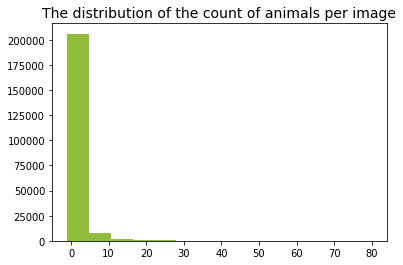

In [11]:
plt.hist(counts_per_image['count'].values, bins=14, color='#91bd3a')
plt.title('The distribution of the count of animals per image', fontsize=14)
plt.show()

We can see that:
* most of the images are empty;
* having more than 20 animals on one image is very rare.

`3` Let's look at the number of different categories of animals per image:

In [12]:
# get the number of counts per image
# sort values in descending order
category_counts_per_image = train_annotations.groupby(by=['image_id', 'category_id']).sum().reset_index()[['image_id', 'category_id', 'count']]\
.sort_values(by=['count'], ascending=False)
# merge with category names
category_counts_per_image = category_counts_per_image.merge(train_categories[['id', 'name']].rename(columns={'id':'category_id'}), on=['category_id'])
# output top-5
category_counts_per_image.head(5)

,image_id,category_id,count,name
0,91d0f146-21bc-11ea-a13a-137349068a90,71,80,bos taurus
1,97062316-21bc-11ea-a13a-137349068a90,71,75,bos taurus
2,8a28c004-21bc-11ea-a13a-137349068a90,71,75,bos taurus
3,89eab214-21bc-11ea-a13a-137349068a90,71,75,bos taurus
4,9926a95e-21bc-11ea-a13a-137349068a90,71,70,bos taurus


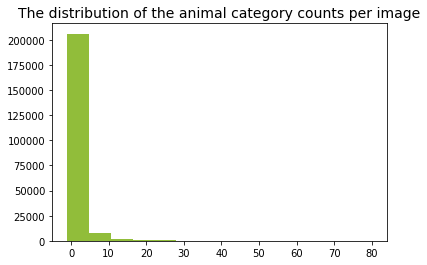

In [13]:
plt.hist(category_counts_per_image['count'].values, bins=14, color='#91bd3a')
plt.title('The distribution of the animal category counts per image', fontsize=14)
plt.show()

This distribution is quite similar to the number of the animals per image.

`4` Now let's look at the number of images for each category:

In [14]:
# sort the categories in descending order
num_categories = train_categories.sort_values(by=['count'], ascending=False)
# list the top-5
num_categories.head(5)

,count,id,name
0,78981,0,empty
36,33313,75,human
188,16713,372,meleagris ocellata
189,12908,374,crax rubra
146,9052,317,cephalophus nigrifrons


In [15]:
num_categories.tail(5)

,count,id,name
158,0,329,melaenornis ardesiacus
211,0,411,sundasciurus hippurus
101,0,188,chelonoidis carbonaria
59,0,109,xerus erythropus
160,0,331,nectarinia cyanolaema


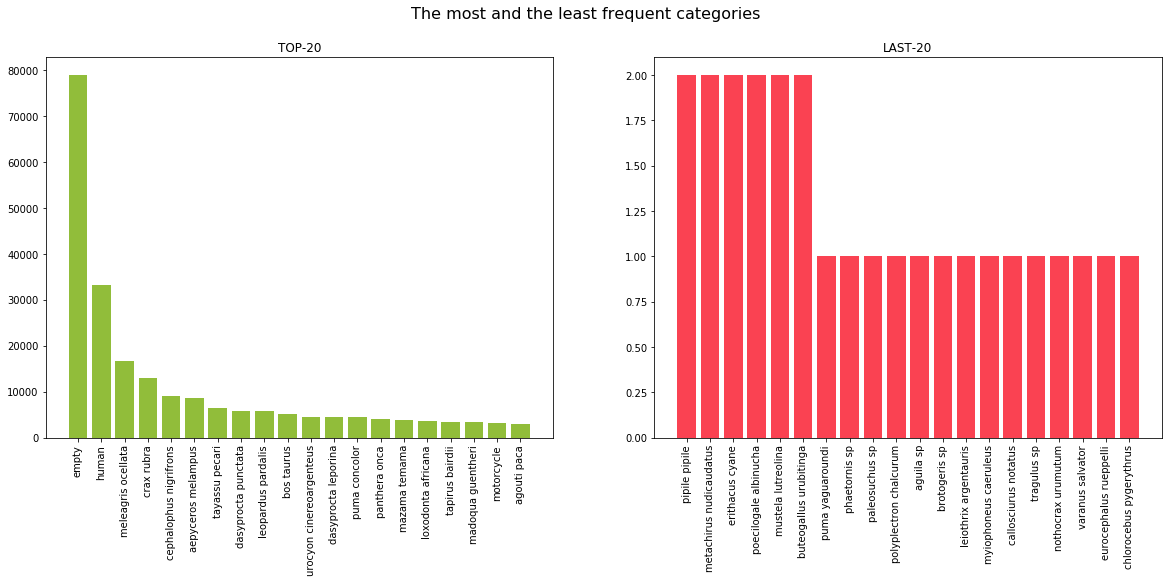

In [16]:
fig, axs = plt.subplots(1,2, figsize=(20,7))
width = 0.8
n_categories = 20
# plot the top-n
axs[0].bar(x=range(n_categories), height=num_categories['count'].values[:n_categories], width=width, color='#91bd3a')
axs[0].set_xticks(np.array(range(n_categories)))
axs[0].set_xticklabels(num_categories['name'].values[:n_categories], rotation=90)
axs[0].set_title('TOP-{}'.format(n_categories))
# plot the tail-n
axs[1].bar(x=range(n_categories), height=num_categories[num_categories['count'] > 0]['count'].values[-n_categories:], width=width, color='#fa4252')
axs[1].set_xticks(np.array(range(n_categories)))
axs[1].set_xticklabels(num_categories[num_categories['count'] > 0]['name'].values[-n_categories:], rotation=90)
axs[1].set_title('LAST-{}'.format(n_categories))

plt.suptitle('The most and the least frequent categories', fontsize=16)
plt.show()

Some quick conclusions:

* Most of the images are empty;
* A lot of images captured humans;
* Some of the categories were not captured at all;
* The least frequent categories were captured by cameras just once!

`5` Let's explore the locations related to the train set images:

In [17]:
print('The number of unique locations is {}'.format(train_images.location.nunique()))
print('The average number of images per location is {}'.format(train_images.groupby(by=['location']).id.count().mean()))
print('The minimum number of images per location is {}'.format(train_images.groupby(by=['location']).id.count().min()))
print('The maximum number of images per location is {}'.format(train_images.groupby(by=['location']).id.count().max()))

The number of unique locations is 325
The average number of images per location is 670.6430769230769
The minimum number of images per location is 1
The maximum number of images per location is 8844


The distribution of the number of the images per location:

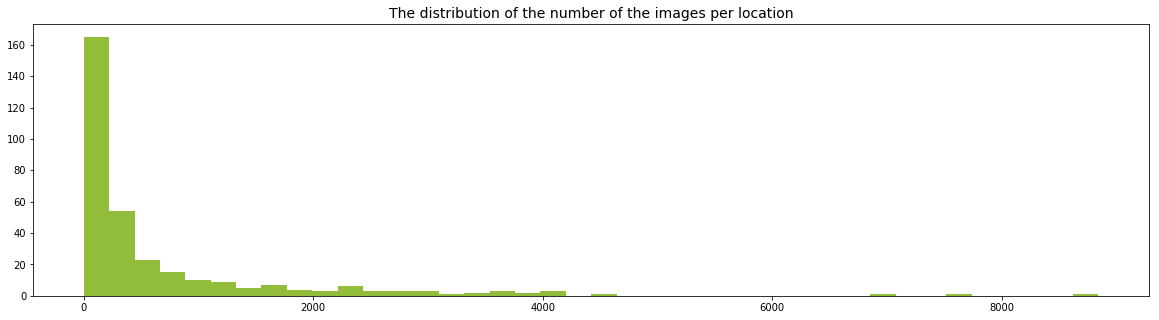

In [18]:
plt.figure(figsize=(20,5))
plt.hist(train_images.groupby(by=['location']).id.count(), bins=40, color='#91bd3a')
plt.title('The distribution of the number of the images per location', fontsize=14)
plt.show()

* Most of the locations have less than 500 images, but for some of the locations the total number of images exceeds 8000.
* For some of the locations there is only 1 image captured! Probably, this is why we want to have models, which extend to different locations.

`6` Analyze the timelines for the captured images:

In [19]:
# convert datetimes to just dates
def to_date(datetime_str):
    """Convert datetime string to date."""
    # datetime string example: 2013-08-08 11:45:00.000
    dt = datetime_str.split(' ')[0]
    return dt
    
train_images['date'] = train_images.apply(lambda row: to_date(row.datetime), axis=1)
# group by date
img_per_date = train_images.groupby(by=['date']).id.count()

In [20]:
print('The average number of images per day is {}'.format(img_per_date.mean()))
print('The maximum number of images per day is {}'.format(img_per_date.max()))
print('The minimum number of images per day is {}'.format(img_per_date.min()))

The average number of images per day is 569.0835509138382
The maximum number of images per day is 4741
The minimum number of images per day is 1


In [21]:
# visualize the number of images for each date
# normalize dates
max_date = datetime.strptime(img_per_date.index[-1], '%Y-%m-%d')
min_date = datetime.strptime(img_per_date.index[0], '%Y-%m-%d')

def get_date_norm(date_str):
    """Helper function to get the noemalized date."""
    date = datetime.strptime(date_str, '%Y-%m-%d')
    return (date - min_date) * 1.0 / (max_date - min_date)
    
copy = img_per_date.reset_index().copy()
copy['date_norm'] = copy.apply(lambda row: get_date_norm(row.date), axis=1)

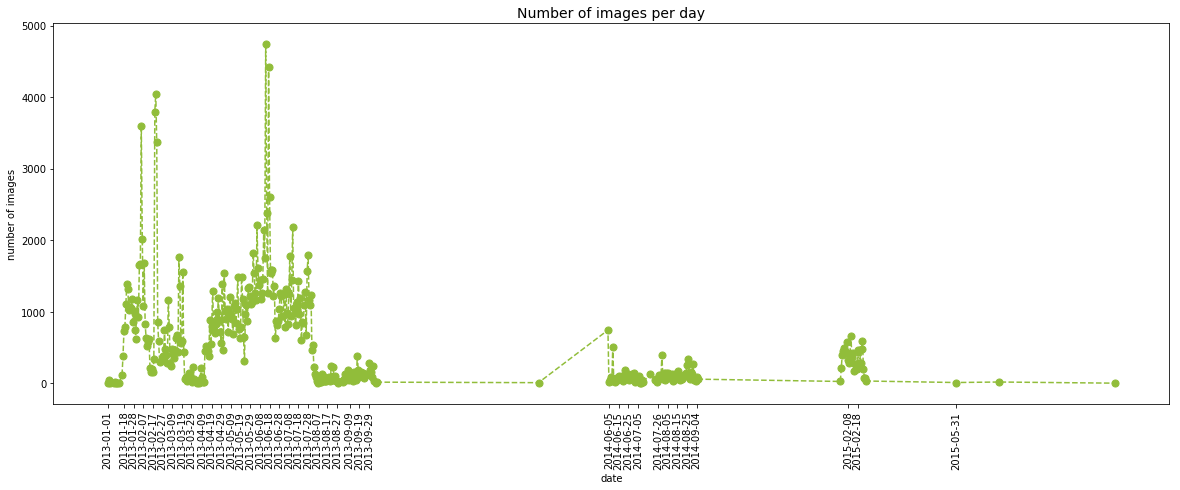

In [22]:
# plot the scatter plot
plt.figure(figsize=(20, 7))
plt.plot(copy.date_norm, copy.id, color='#91bd3a', linestyle='--')
plt.scatter(copy.date_norm, copy.id, s=50, color='#91bd3a')
plt.xticks([copy.date_norm[i] for i in range(0,len(copy),10)], [copy.date[i] for i in range(0,len(copy),10)], rotation=90)

plt.title('Number of images per day', fontsize=14)
plt.xlabel('date')
plt.ylabel('number of images')
plt.show()

* Most of the data is collected in January - September 2013;
* More than 4700 images are captured on single day;
* Just 1 image is capture on some days.

`7` Analyze the number of frames in sequences:

In [23]:
# group by sequence id
frames_per_sequence = train_images.groupby(by=['seq_id']).frame_num.max()

print('The average number of frames is {}'.format(frames_per_sequence.mean()))
print('The minimum number of frames is {}'.format(frames_per_sequence.min()))
print('The maximum number of frames is {}'.format(frames_per_sequence.max()))

The average number of frames is 6.170176231360145
The minimum number of frames is -1
The maximum number of frames is 3899


The distribution of the number of frames in sequences:

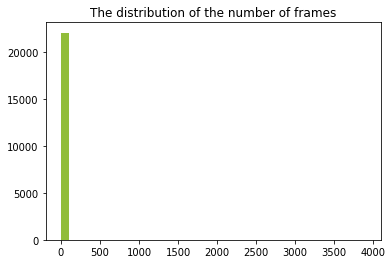

In [24]:
plt.hist(frames_per_sequence.values, bins=40, color='#91bd3a')
plt.title('The distribution of the number of frames')
plt.show()

The number of frames in sequences is mostly small. Large sequences are exceptions.

`8` Explore the dimensions of the images:

In [25]:
print('The minimum width of the images is {}'.format(train_images.width.min()))
print('The maximum width of the images is {}'.format(train_images.width.max()))
print('The minimum height of the images is {}'.format(train_images.height.min()))
print('The maximum height of the images is {}'.format(train_images.height.max()))

The minimum width of the images is -1
The maximum width of the images is 3565
The minimum height of the images is -1
The maximum height of the images is 2226


The `-1` are the very strange values for the width and height.

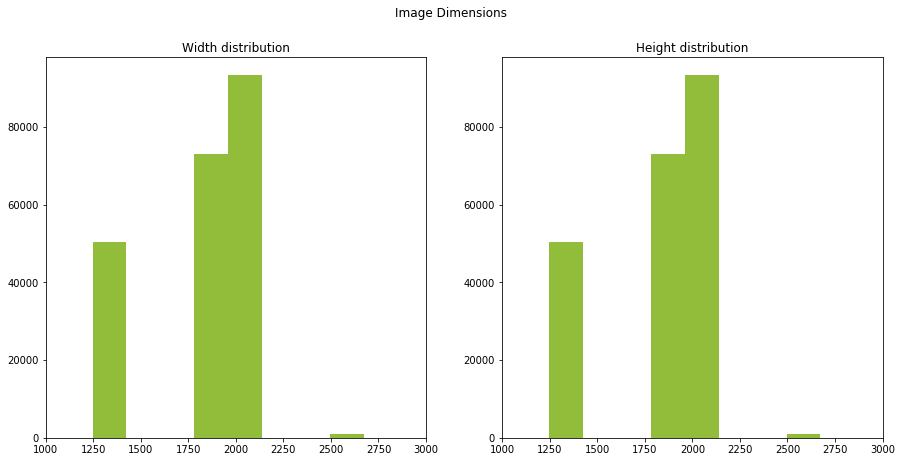

In [26]:
# plot histograms to show the distribution of width and height values
fig, axs = plt.subplots(1,2, figsize=(15,7))
axs[0].hist(train_images.width.values, bins=20, color = '#91bd3a')
axs[0].set_title('Width distribution')
axs[0].set_xlim(1000, 3000)

axs[1].hist(train_images.width.values, bins=20, color = '#91bd3a')
axs[1].set_title('Height distribution')
axs[1].set_xlim(1000, 3000)

plt.suptitle('Image Dimensions')
plt.show()

The dimensions of the images vary greatly.

## Train Set Images Exploration

`1` Visualize random images from the train set and their categories (just one first category):

In [27]:
def get_first_category(img_id):
    """Find first the image category by id."""
    # get category id
    category_id = train_annotations[train_annotations.image_id == img_id].category_id.values[0]
    # get category name
    category_name = train_categories[train_categories.id == category_id].name.values[0]
    return category_id, category_name

def visualize_image_grid(rows, cols):
    """Visualize random grid of images with the first category."""
    filenames = train_images.file_name.unique()
    
    np.random.seed(42)
    img_idx = np.random.randint(len(filenames), size=rows * cols)
    
    fig, axs = plt.subplots(rows, cols, figsize=(15,7))
    
    for r in range(rows):
        for c in range(cols):
            # get the image and image id
            filename = filenames[img_idx[rows*r + c]]
            img_id = filename.split('.')[0]
            # get the category
            category_id, category = get_first_category(img_id)
            
            img = Image.open(TRAIN_DIR + filename)
            
            axs[r,c].imshow(img)
            axs[r,c].axis('off')
            axs[r,c].set_title('{}:{}'.format(category_id, category))
            
    plt.suptitle('Train images', fontsize=16)
    plt.show()

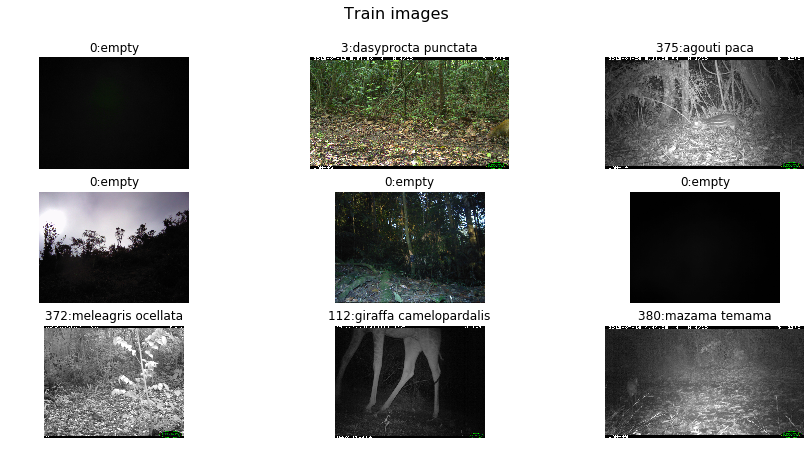

In [28]:
visualize_image_grid(3, 3)

We can see that there are images of different sizes with different lighting conditions. For some of the images it is hard even for a human to find an animal. 

`2` Visualize images for a specific category

In [29]:
def visualize_cetagory(category_id, rows=3, cols=3, seed=42):
    """Function to visualize images of a specific category."""
    # filter by the category_id
    copy = train_annotations[train_annotations.category_id == category_id]
    # get the category name
    category_name = train_categories[train_categories.id == category_id].name.values[0]
    
    # get random indices
    np.random.seed(seed)
    img_idx = np.random.randint(len(copy), size=rows * cols)
    
    # plot images
    fig, axs = plt.subplots(rows, cols, figsize=(15,7))
    
    for r in range(rows):
        for c in range(cols):
            # get the image and image id
            filename = copy.iloc[img_idx[rows*r + c]].image_id + '.jpg'
            img_id = filename.split('.')[0]
            
            img = Image.open(TRAIN_DIR + filename)
            
            axs[r,c].imshow(img)
            axs[r,c].axis('off')
            axs[r,c].set_title('{}:{}'.format(category_id, category_name))
            
    plt.suptitle('Train images for {}:{}'.format(category_id, category_name), fontsize=16)
    plt.show()

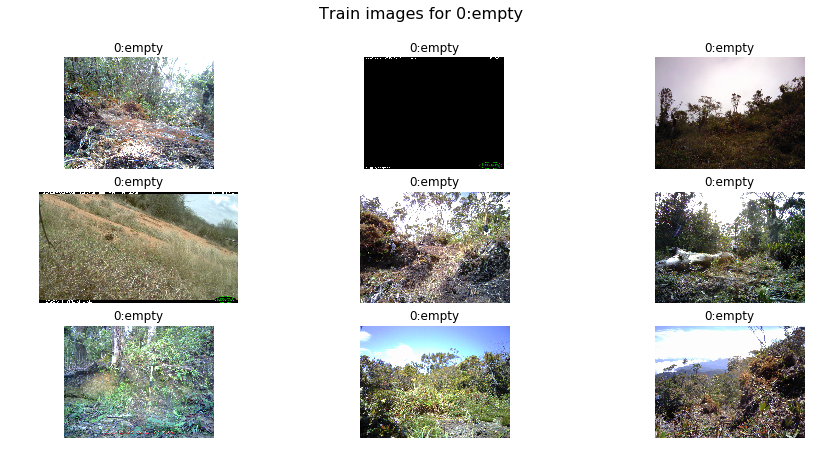

In [30]:
visualize_cetagory(0)

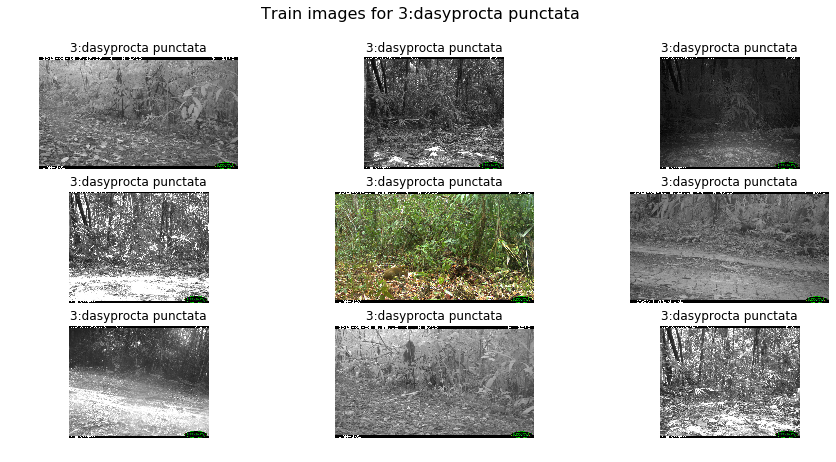

In [31]:
# central american agouty
# https://en.wikipedia.org/wiki/Central_American_agouti
visualize_cetagory(3) 

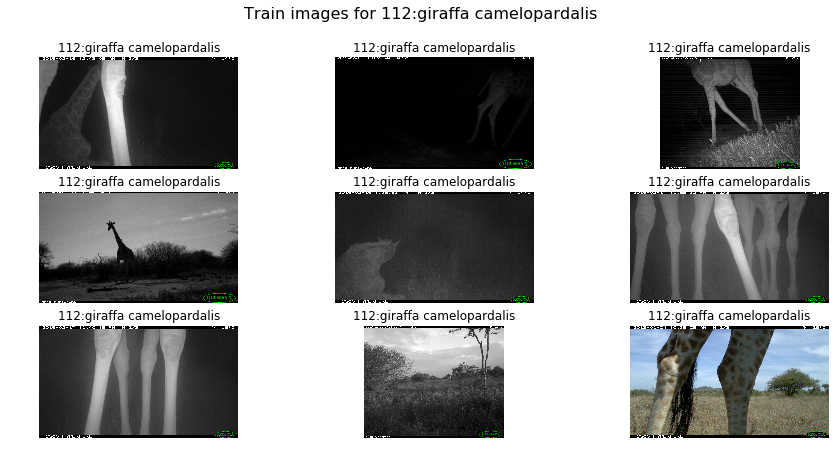

In [32]:
# giraffe
# https://en.wikipedia.org/wiki/Giraffe
visualize_cetagory(112) 

It seems that we can mostly see his legs 🦒.

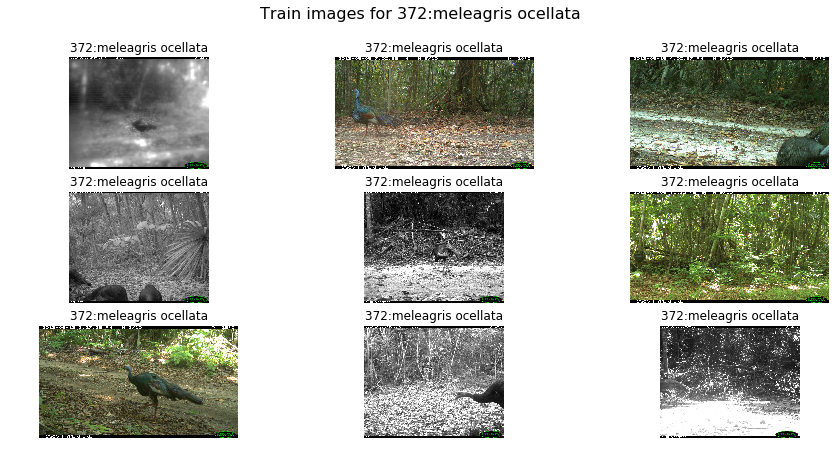

In [33]:
# Ocellated turkey
# https://en.wikipedia.org/wiki/Ocellated_turkey
visualize_cetagory(372) 

`3` Visualize images for top categories:

In [34]:
def visualize_top_categories(n_categories=5, n_cols=5, seed=42):
    """Function to plot a grid of n_cols images for each of the top n_categories from the train set."""
    np.random.seed(seed)
    
    # get ids for the top n_categories
    # excluding empty and human
    top_categories = num_categories['id'].values[2:n_categories+2]
    
    # setup the image grid
    fig, axs = plt.subplots(n_categories, n_cols, figsize=(18,10))
    
    for row in range(0, n_categories):
        # get the category 
        category_id = top_categories[row]
        
        # get the category name
        category_name = train_categories[train_categories.id == category_id].name.values[0]
        
        # filter the images by category
        copy = train_annotations[train_annotations.category_id == category_id]
        
        # get random indices
        img_idx = np.random.randint(len(copy), size=n_cols)
        
        for col in range(0, n_cols):
            # get the image and image id
            filename = copy.iloc[img_idx[col]].image_id + '.jpg'
            img_id = filename.split('.')[0]
            
            img = Image.open(TRAIN_DIR + filename)
            
            axs[row,col].imshow(img)
            axs[row,col].axis('off')
            axs[row,col].set_title('{}:{}'.format(category_id, category_name))
            
    plt.suptitle('Train images for top-{} categories'.format(n_categories), fontsize=16)
    plt.show()

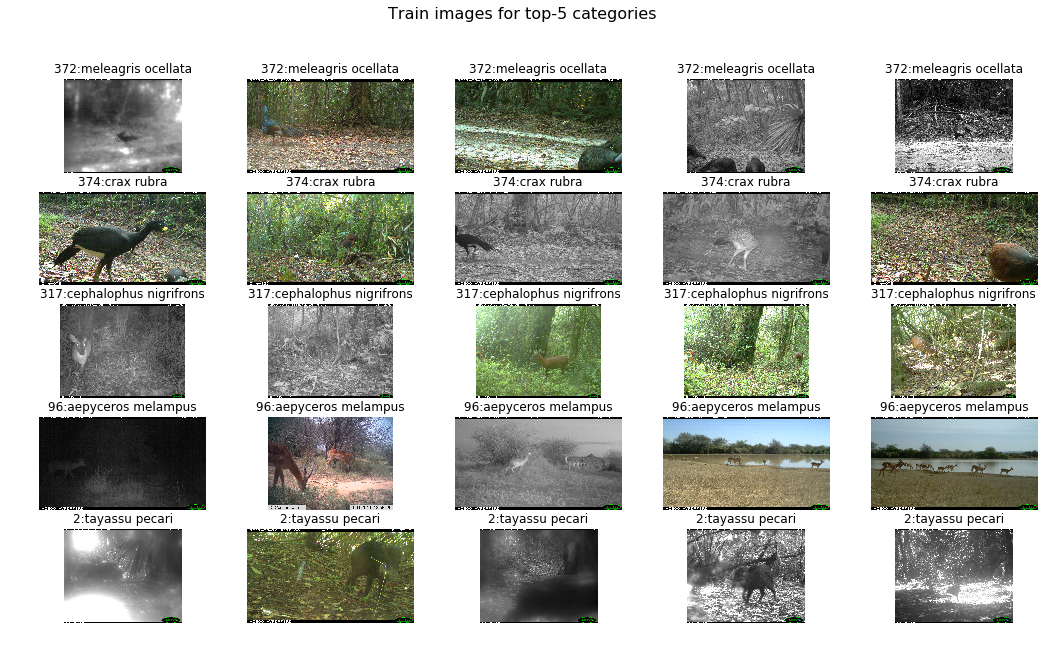

In [35]:
visualize_top_categories(n_categories=5)

## References

Some papers and github repos you may find helpful for the competition:
1. [Efficient Method for Categorize Animals in the Wild](https://arxiv.org/pdf/1907.13037v1.pdf):  We transfer the state-of-the-art ImagaNet pretrained models to the problem. To improve the generalization and robustness of the model, we utilize efficient image augmentation and regularization strategies, like cutout, mixup and label-smoothing. Finally, we use ensemble learning to increase the performance of the model. [Github repo](https://github.com/Walleclipse/iWildCam_2019_FGVC6)
2. [Animal Classification System: A Block Based Approach](https://arxiv.org/pdf/1609.01829v1.pdf): In this work, we propose a method for the classification of animal in images. Initially, a graph cut based method is used to perform segmentation in order to eliminate the background from the given image. The segmented animal images are partitioned in to number of blocks and then the color texture moments are extracted from different blocks. Probabilistic neural network and K-nearest neighbors are considered here for classification. To corroborate the efficacy of the proposed method, an experiment was conducted on our own data set of 25 classes of animals, which consisted of 4000 sample images. The experiment was conducted by picking images randomly from the database to study the effect of classification accuracy, and the results show that the K-nearest neighbors classifier achieves good performance.

## Conclusion
In this notebook I observed:
1. The statistics for the images from the train set:
    * the number of images;
    * the number of categories per image;
    * the number of images per category;
    * the number of images per day.
2. The examples of the images from the train set.

__The notebook is being updated. Your comments are very welcome!__